In [1]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

import chainer
import chainer.functions as F
import chainer.links as L
import chainer.initializers as I

from ipywidgets import widgets
from ipywidgets.widgets import *
from IPython.display import display

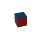

In [37]:
points = np.array([[-1, -1, -1],
                      [1, -1, -1 ],
                      [1, 1, -1],
                      [-1, 1, -1],
                      [-1, -1, 1],
                      [1, -1, 1 ],
                      [1, 1, 1],
                      [-1, 1, 1]])

fig = plt.figure(figsize=(0.35,0.35))
canvas = FigureCanvas(fig)
ax = fig.add_subplot(111, projection='3d')
r = [-1,1]
X, Y = np.meshgrid(r, r)
ax.plot_surface(X,Y,1)
ax.plot_surface(X,Y,-1)
ax.plot_surface(X,-1,Y)
ax.plot_surface(X,1,Y)
ax.plot_surface(1,X,Y)
ax.plot_surface(-1,X,Y)
plt.axis('off')
def get_yaw(i):
    return i * np.pi / 2 / 5
def get_pitch(i): return i * np.pi / 4 / 5
yaw_angles = get_yaw(np.arange(5))
pitch_angles = get_pitch(np.arange(5))
yaw_mat, pitch_mat = np.meshgrid(yaw_angles, pitch_angles)
images = []
for pitch in pitch_angles:
    for yaw in yaw_angles:
        ax.view_init(pitch * 180 / np.pi, yaw * 180 / np.pi)
        canvas.draw()
        rawimage = np.fromstring(canvas.tostring_rgb(), dtype='uint8')
        image = rawimage.reshape((int(np.sqrt(len(rawimage) // 3)), -1, 3))
        cropimage = image[4:-4, 4:-4, :]
        rawcropimage = np.array(cropimage.flat)
        images.append(rawcropimage)

In [3]:
print(np.array(images).max())

255


(867,)
(17, 17, 3)


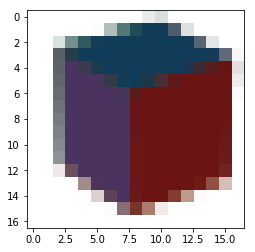

In [38]:
def plotimg(yaw,pitch):
    print(images[yaw + pitch * len(yaw_angles)].shape)
    image = images[yaw + pitch * len(yaw_angles)]
    img = image.reshape((int(np.sqrt(len(image) // 3)), -1, 3))
    print(img.shape)
    plt.imshow(img)
    k = np.arange(50)

interact(plotimg, yaw=(0,len(yaw_angles)-1,1), pitch=(0,len(pitch_angles)-1,1));

In [5]:
class Regressor(chainer.Chain):
    def __init__(self, outputs=1, n_units=128):
        super(Regressor, self).__init__(
            l1 = L.Linear(None, n_units),
            l2 = L.Linear(n_units, outputs)
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = self.l2(h1)
        return h2

In [53]:
class Regressor2(chainer.Chain):
    def __init__(self, outputs=1, n_units=128, output=F.sigmoid):
        self.output = output
        super(Regressor2, self).__init__(
            l1 = L.Linear(None, n_units),
            l2 = L.Linear(n_units, n_units),
            l3 = L.Linear(n_units, outputs)
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.output(self.l3(h2)) * 255

In [7]:
class CNNRegressor2(chainer.Chain):
    def __init__(self, outputs=1, n_units=128):
        super(CNNRegressor2, self).__init__(
            conv1 = L.Convolution2D(None, n_units, ksize=3),
            l2 = L.Linear(n_units, n_units),
            l3 = L.Linear(n_units, outputs)
        )

    def __call__(self, x):
        h1 = self.conv1(x)
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [28]:
def run_train(trainx, trainy, epoch=10000, report_period=100, report_period_seconds=0, regularize=0.0001,
              model=None, optimizer=None):
    from time import clock
    start = clock()
    last_report = start

    if model == None:
        model = Regressor2(trainy.shape[1], 512)
        model.zerograds()

    if optimizer == None:
        optimizer = chainer.optimizers.Adam()
        optimizer.setup(model)
        optimizer.add_hook(chainer.optimizer.WeightDecay(regularize))
    loss_hist = []

    try:
        for i in range(epoch):
            loss = F.mean_squared_error(model(trainx), trainy)
            loss_hist.append(loss.data)
            if i % report_period == 0:
                if last_report + report_period_seconds < clock():
                    ups = i / (clock() - start)
                    eta = (epoch - i) / ups if ups != 0 else 0
                    etas = '%d:%05.2f' % (eta // 60, eta % 60) if 60 < eta else '%.2f' % eta
                    print(i, 'loss', loss.data, ', ups: %.2f' % ups, ', eta: ' + etas)
                    last_report = clock()
            #optimizer.weight_decay(0.005)
            optimizer.update(lambda x,y: F.mean_squared_error(model(x), y), trainx, trainy)
    except KeyboardInterrupt:
        print('Interrupted')

    return model, loss_hist, optimizer

In [39]:
use_flat = True
if use_flat:
    x = y = range(int(np.sqrt(len(images[0]) // 3)))
    print(len(x))
    A, P, X, Y = np.meshgrid(yaw_angles, pitch_angles, x, y)
    print(X.shape, Y.shape, A.shape[0] * A.shape[1] * A.shape[2])
    APXY = np.vstack([A.flat, P.flat, np.array(X.flat), np.array(Y.flat)]).astype(np.float32).T
    trainx = APXY
    print(APXY.shape, 'image: ', images[0].shape)
    imageXY = np.zeros((trainx.shape[0],3))
    i = 0
    for image in images:
        imageXY[i:(i+image.shape[0]//3),:] = image.reshape((-1,3))
        i += image.shape[0]//3
    trainy = np.array(imageXY, dtype=np.float32)
else:
    trainx = np.vstack([yaw_mat.flat, pitch_mat.flat]).astype(np.float32).T
    trainy = np.array(images, dtype=np.float32)
print(trainx.shape, trainy.shape)


17
(5, 5, 17, 17) (5, 5, 17, 17) 425
(7225, 4) image:  (867,)
(7225, 4) (7225, 3)


In [59]:
model, loss_hist, optimizer = run_train(trainx, trainy, epoch=1000, report_period=10, report_period_seconds=5, regularize=0.00001)

30 loss 19347.75 , ups: 4.17 , eta: 3:52.54
60 loss 18804.419921875 , ups: 4.20 , eta: 3:43.91
90 loss 17174.271484375 , ups: 4.20 , eta: 3:36.66
120 loss 15581.1708984375 , ups: 4.21 , eta: 3:28.81
150 loss 15052.7841796875 , ups: 4.22 , eta: 3:21.30
180 loss 14935.458984375 , ups: 4.22 , eta: 3:14.17
210 loss 14860.3544921875 , ups: 4.23 , eta: 3:06.97
230 loss 14829.3564453125 , ups: 4.20 , eta: 3:03.37
260 loss 14741.681640625 , ups: 4.20 , eta: 2:56.29
290 loss 14691.25390625 , ups: 4.20 , eta: 2:49.15
320 loss 14626.859375 , ups: 4.20 , eta: 2:42.00
350 loss 14750.619140625 , ups: 4.20 , eta: 2:34.81
380 loss 14526.953125 , ups: 4.20 , eta: 2:27.52
410 loss 14536.7255859375 , ups: 4.21 , eta: 2:20.28
440 loss 14446.7412109375 , ups: 4.21 , eta: 2:13.02
470 loss 14522.923828125 , ups: 4.21 , eta: 2:05.93
490 loss 14659.248046875 , ups: 4.20 , eta: 2:01.50
520 loss 14364.23046875 , ups: 4.20 , eta: 1:54.30
550 loss 14381.9091796875 , ups: 4.20 , eta: 1:47.13
580 loss 14374.42675781

In [72]:
model, loss_hist, optimizer = run_train(trainx, trainy, epoch=1000, report_period=10, report_period_seconds=5, regularize=0.00001, model=model, optimizer=optimizer)

10 loss 527.3958740234375 , ups: 1.94 , eta: 8:30.85
30 loss 432.30316162109375 , ups: 1.95 , eta: 8:18.10
50 loss 349.38397216796875 , ups: 1.98 , eta: 8:00.22
70 loss 366.4877624511719 , ups: 2.00 , eta: 7:46.10
90 loss 485.3014221191406 , ups: 2.00 , eta: 7:34.03
110 loss 469.7373046875 , ups: 2.01 , eta: 7:23.20
130 loss 453.2388610839844 , ups: 2.01 , eta: 7:12.17
150 loss 319.47491455078125 , ups: 2.01 , eta: 7:02.74
170 loss 389.8663024902344 , ups: 2.01 , eta: 6:52.19
190 loss 346.74786376953125 , ups: 2.02 , eta: 6:41.44
210 loss 378.10809326171875 , ups: 2.02 , eta: 6:30.93
230 loss 340.5108337402344 , ups: 2.02 , eta: 6:20.35
250 loss 303.6778259277344 , ups: 2.03 , eta: 6:10.02
270 loss 448.6180419921875 , ups: 2.03 , eta: 6:00.05
290 loss 357.6990966796875 , ups: 2.03 , eta: 5:49.93
310 loss 340.9999694824219 , ups: 2.03 , eta: 5:39.94
330 loss 359.30438232421875 , ups: 2.03 , eta: 5:29.90
350 loss 367.1171875 , ups: 2.03 , eta: 5:19.82
370 loss 373.2620544433594 , ups: 2.

D:\Programs\Anaconda3\lib\site-packages\chainer\functions\activation\relu.py:31: RuntimeWarning: invalid value encountered in maximum
  return utils.force_array(numpy.maximum(x[0], 0, dtype=x[0].dtype)),
D:\Programs\Anaconda3\lib\site-packages\chainer\functions\activation\relu.py:48: RuntimeWarning: invalid value encountered in greater
  return utils.force_array(gy[0] * (y > 0)),


500 loss nan , ups: 2.07 , eta: 4:01.93
530 loss nan , ups: 2.13 , eta: 3:40.59
560 loss nan , ups: 2.19 , eta: 3:21.08
590 loss nan , ups: 2.25 , eta: 3:02.56
620 loss nan , ups: 2.30 , eta: 2:45.15
650 loss nan , ups: 2.35 , eta: 2:28.76
680 loss nan , ups: 2.40 , eta: 2:13.22
710 loss nan , ups: 2.45 , eta: 1:58.39
740 loss nan , ups: 2.50 , eta: 1:44.20
770 loss nan , ups: 2.54 , eta: 1:30.59
800 loss nan , ups: 2.58 , eta: 1:17.54
830 loss nan , ups: 2.62 , eta: 1:04.99
860 loss nan , ups: 2.65 , eta: 52.77
890 loss nan , ups: 2.69 , eta: 40.89
920 loss nan , ups: 2.72 , eta: 29.37
950 loss nan , ups: 2.76 , eta: 18.13
980 loss nan , ups: 2.79 , eta: 7.17


In [71]:
chainer.serializers.save_npz("result/image3d3.model", model)

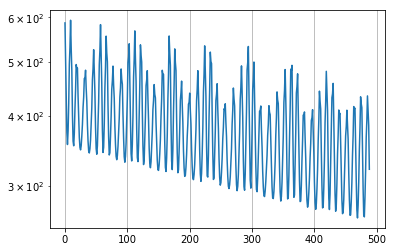

In [73]:
plt.semilogy(loss_hist)
plt.grid()

(1, 6912) 5.31971e-05 255.0


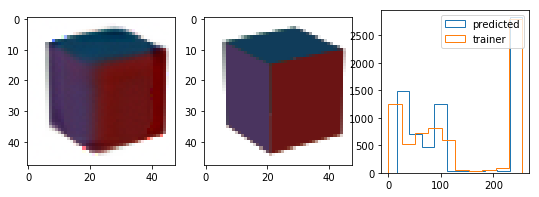

In [17]:
def plotimg(yaw,pitch):
    predicted = model(np.array([get_yaw(yaw), get_pitch(pitch)], dtype=np.float32)[np.newaxis]).data
    print(predicted.shape, predicted.min(), predicted.max())
    xs = int(np.sqrt(predicted.shape[1] // 3))
    img = predicted.reshape((xs, -1, 3))
    fig, ax = plt.subplots(1, 3, figsize=(9,3))
    ax[0].imshow(img / 255)
    if 0 <= yaw and yaw < len(yaw_angles) and 0 <= pitch and pitch < len(pitch_angles):
        image = images[yaw + pitch * len(yaw_angles)]
        img2 = image.reshape((int(np.sqrt(len(image) // 3)), -1, 3))
        ax[1].imshow(img2)
        ax[2].hist(img2.flat, histtype='step')
    ax[2].hist(predicted.flat, histtype='step')
    ax[2].legend(['predicted', 'trainer'])

interact(plotimg, yaw=(-10,len(yaw_angles)+10,1), pitch=(-10,len(pitch_angles)+10,1));

(289, 3) 17 5
(17, 17, 3)


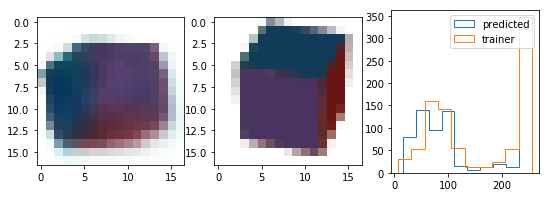

In [70]:
def plotimg(yaw,pitch):
    X, Y = np.meshgrid(x,y)
    XYA = np.vstack([np.ones(X.shape[0] * X.shape[1]) * yaw_angles[yaw],
                     np.ones(X.shape[0] * X.shape[1]) * pitch_angles[pitch],
                     np.array(X.flat), np.array(Y.flat)]).astype(np.float32).T
    predicted = model(XYA).data
    xs = int(np.sqrt(len(images[0]) // 3))
    print(predicted.shape, xs, predicted.shape[0] // (3 * xs))
    img = predicted.reshape((xs, -1, 3))
    print(img.shape)
    fig, ax = plt.subplots(1, 3, figsize=(9,3))
    ax[0].imshow(img / 255)
    if 0 <= yaw and yaw < len(yaw_angles) and 0 <= pitch and pitch < len(pitch_angles):
        image = images[yaw + pitch * len(yaw_angles)]
        img2 = image.reshape((int(np.sqrt(len(image) // 3)), -1, 3))
        ax[1].imshow(img2)
        ax[2].hist(img2.flat, histtype='step')
    ax[2].hist(predicted.flat, histtype='step')
    ax[2].legend(['predicted', 'trainer'])

interact(plotimg, yaw=(0,len(yaw_angles)-1,1), pitch=(0,len(pitch_angles)-1,1));